# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2 - Алгоритмы кластеризации
## Докшина Елизавета

###### <hr\>
**Общая информация**

**Срок сдачи:** 23 октября 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 23 октября, -4 балла после 06:00 30 октября, -6 баллов после 06:00 6 ноября

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

###### Задание 1 (4 балла)
Реализовать алгоритм кластеризации, который относится к вашему варианту. Проверить работоспособность алгоритма на "Iris". Сравните свой алгоритм кластеризации с алгоритмом из scikit-learn по времени выполнения, использую timeit. Ваша реализация не должна работать сильно дольше, а в идеале должна быть даже немного быстрее.

###### Задание 2 (2 балла)
Выбрать, имплементировать и использовать критерий качества

###### Задание 3 (3балла)
Применить алгоритм кластеризации к данным по странам.   
Подход следующий: фиксируем год, для каждой страны берём индикаторы по зафиксированному году, кластеризуем по индикаторам.   
Разбиение должно быть объяснимым, в противном случае, скорее всего нужно лучше настроить параметры кластеризации.   
Данные нужно скачать тут https://data.worldbank.org/data-catalog/world-development-indicators.   
Также необходимо показать, какие страны попали в общий кластер.
изуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время.

###### Задание 4 (1 балл)
Опишите в выводе почему и какие страны попали в общий кластер.

Основная задача этого задания - реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from scipy.spatial.distance import cdist
from itertools import combinations
from collections import Counter
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

import matplotlib.pyplot as plt
import mpl_toolkits.basemap as bm

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20,10)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Реализация алгоритма

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего порядкового номера в списке группы.

In [2]:
N = 16 # put your index here

In [18]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[N % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [526]:
## Задание 1
from sklearn.base import BaseEstimator, ClusterMixin

class Hierarchical(BaseEstimator, ClusterMixin):

    def __init__(self, k, linkage='single'):
        self.k = k # число кластеров
        self.linkage = linkage
        self.dend = []

    def distances_recount(self, new_clust, x, y):
        # Пересчет расстояний между кластерами
        
        if self.linkage == 'single': 
            for k in xrange(new_clust):
                self.distances[new_clust][k] = min(self.distances[x][k], self.distances[y][k])
                self.distances[k][new_clust] = self.distances[new_clust][k]
                
        elif self.linkage == 'complete': 
            for k in xrange(new_clust):
                self.distances[new_clust][k] = max(self.distances[x][k], self.distances[y][k])
                self.distances[k][new_clust] = self.distances[new_clust][k]
                
        elif self.linkage == 'average':
            for k in xrange(new_clust):
                self.distances[new_clust][k] = (self.distances[x][k] + self.distances[y][k]) / 2
                self.distances[k][new_clust] = self.distances[new_clust][k]
        
    def merge(self, x, y):
        # Слияние двух кластеров
        
        self.distances_recount(self.max_label, x, y)
        self.labels[self.labels == x] = self.max_label
        self.labels[self.labels == y] = self.max_label
                   
        self.max_label += 1 
        return len(self.labels[self.labels == self.max_label - 1])
        
    def fit(self, X, y=None):
        self.n = X.shape[0]
        self.clusters_num = self.n
        self.labels = np.arange(self.n)
        self.max_label = self.n
        self.X = X
        self.distances = np.zeros((self.n * 2, self.n * 2))
        
        for x, y in combinations(self.labels, 2):              
            self.distances[y][x]  = self.distances[x][y] = cdist(self.X[self.labels == x], self.X[self.labels == y])

        while self.clusters_num > 1:
            min_dist = np.inf
            c1 = c2 = None
            labels = set(self.labels)

            for x, y in combinations(labels, 2):                
                distance = self.distances[x, y]
            
                if (distance < min_dist):
                    c1 = x
                    c2 = y
                    min_dist = distance

            new_size = self.merge(c1, c2) 
            self.dend.append([c1, c2, min_dist, new_size])
            self.clusters_num -= 1
            
            if self.clusters_num == self.k:
                self.clust_labels = np.copy(self.labels)
            
        return self
    
    def predict(self, X):
        return self.clust_labels
    
    def fit_predict(self, X, y=None):
        self.fit(X, y)
        return self.predict(X)
    
    def get_dend(self):
        return self.dend

In [527]:
iris = ds.load_iris()
X_iris = iris.data[:100]

# Вызываем алгоритм для Iris с single-linkage

In [532]:
%timeit clust = Hierarchical(2, linkage='single')
labels = clust.fit_predict(X=X_iris)

The slowest run took 6.65 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 466 ns per loop


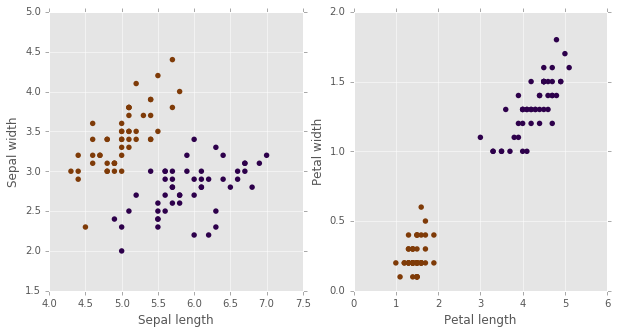

In [529]:
pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(X_iris[:, 0], X_iris[:, 1], c=labels, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(X_iris[:, 2], X_iris[:, 3], c=labels, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

# Дендрограмма

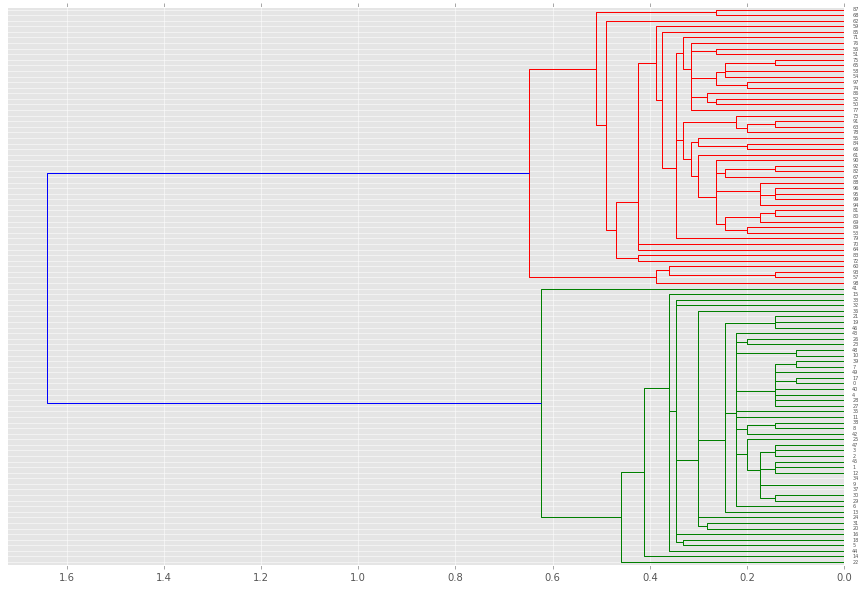

In [523]:
plt.figure(figsize=(15, 10))
d = dendrogram(clust.get_dend(), orientation='left', labels=None)

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

# Adjusted Rand Index

In [524]:
X_iris = iris.data[:100]
Y_iris = iris.target[:100]

In [525]:
pred_iris = Hierarchical(2, linkage='single').fit_predict(X_iris)
print "With single-linkage Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(Y_iris, pred_iris)

pred_iris = Hierarchical(2, linkage='complete').fit_predict(X_iris)
print "With complete-linkage Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(Y_iris, pred_iris)

pred_iris = Hierarchical(2, linkage='average').fit_predict(X_iris)
print "With average-linkage  Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(Y_iris, pred_iris)

With single-linkage Adjusted Rand index for iris is: 1.00
With complete-linkage Adjusted Rand index for iris is: 1.00
With average-linkage  Adjusted Rand index for iris is: 1.00


Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [468]:
## Задание 2
def quality(x, y):
    """
    Implement quality criterion of your choice
    """
    return 0.51

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

In [471]:
ks = range(1, 21)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = Hierarchical(k)
    y = cls.fit_predict(xX)
    criteria[i] = quality(x, y)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

AttributeError: 'int' object has no attribute 'shape'

In [ ]:
## Задание 3

In [ ]:
## Задание 4

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.